# Common

## Imports and Helper Function

In [1]:
# imports
import numpy as np
import math
np.random.seed(42)

# helper function
def print_matop(*matrices, separator="\t\t"):
    # Find the maximum number of rows across all matrices
    max_rows = max(len(matrix) for matrix in matrices)
    
    # Iterate over the rows by index up to the max number of rows
    for i in range(max_rows):
        formatted_rows = []
        for matrix in matrices:
            # Check if the matrix has a row at index i
            if i < len(matrix):
                row = matrix[i]
                # If row is iterable (like a list or numpy array), format each element
                if hasattr(row, '__iter__'):
                    formatted_rows.append("[" + " ".join(f"{val:2.2f}" for val in row) + "]")
                else:
                    # If it's a single scalar value, format it directly
                    formatted_rows.append(f"{row:2.2f}")
            else:
                # Add an empty value if the matrix does not have enough rows
                formatted_rows.append('\t')
        
        # Join the formatted rows with the specified separator and print them
        print(separator.join(formatted_rows))


## Sample Input

In [2]:
# SRAM memory size
M = 20
# simplified head size = hidden size
d = 2
# Sequence length
N = 6

# set block size for outer loop
Bc = math.ceil(M / (4 * d))
print(f"Bc: {Bc}")
# set block size for inner loop
Br = min(Bc, d)
print(f"Br: {Br}")

# Example dimensions for Q, K, V matrices
Q = np.random.randn(N, d)
K = np.random.randn(N, d)
V = np.random.randn(N, d)
with np.printoptions(precision=2, suppress=True):
    print(f"Q \t\t K \t\t V")
    for q, k, v in zip(Q, K, V):
        print(f"{q} \t {k} \t {v}")


Bc: 3
Br: 2
Q 		 K 		 V
[ 0.5  -0.14] 	 [ 0.24 -1.91] 	 [-0.54  0.11]
[0.65 1.52] 	 [-1.72 -0.56] 	 [-1.15  0.38]
[-0.23 -0.23] 	 [-1.01  0.31] 	 [-0.6  -0.29]
[1.58 0.77] 	 [-0.91 -1.41] 	 [-0.6   1.85]
[-0.47  0.54] 	 [ 1.47 -0.23] 	 [-0.01 -1.06]
[-0.46 -0.47] 	 [ 0.07 -1.42] 	 [ 0.82 -1.22]


# Flash Attention 2

## Simplified Forward Pass 

### Algorithm

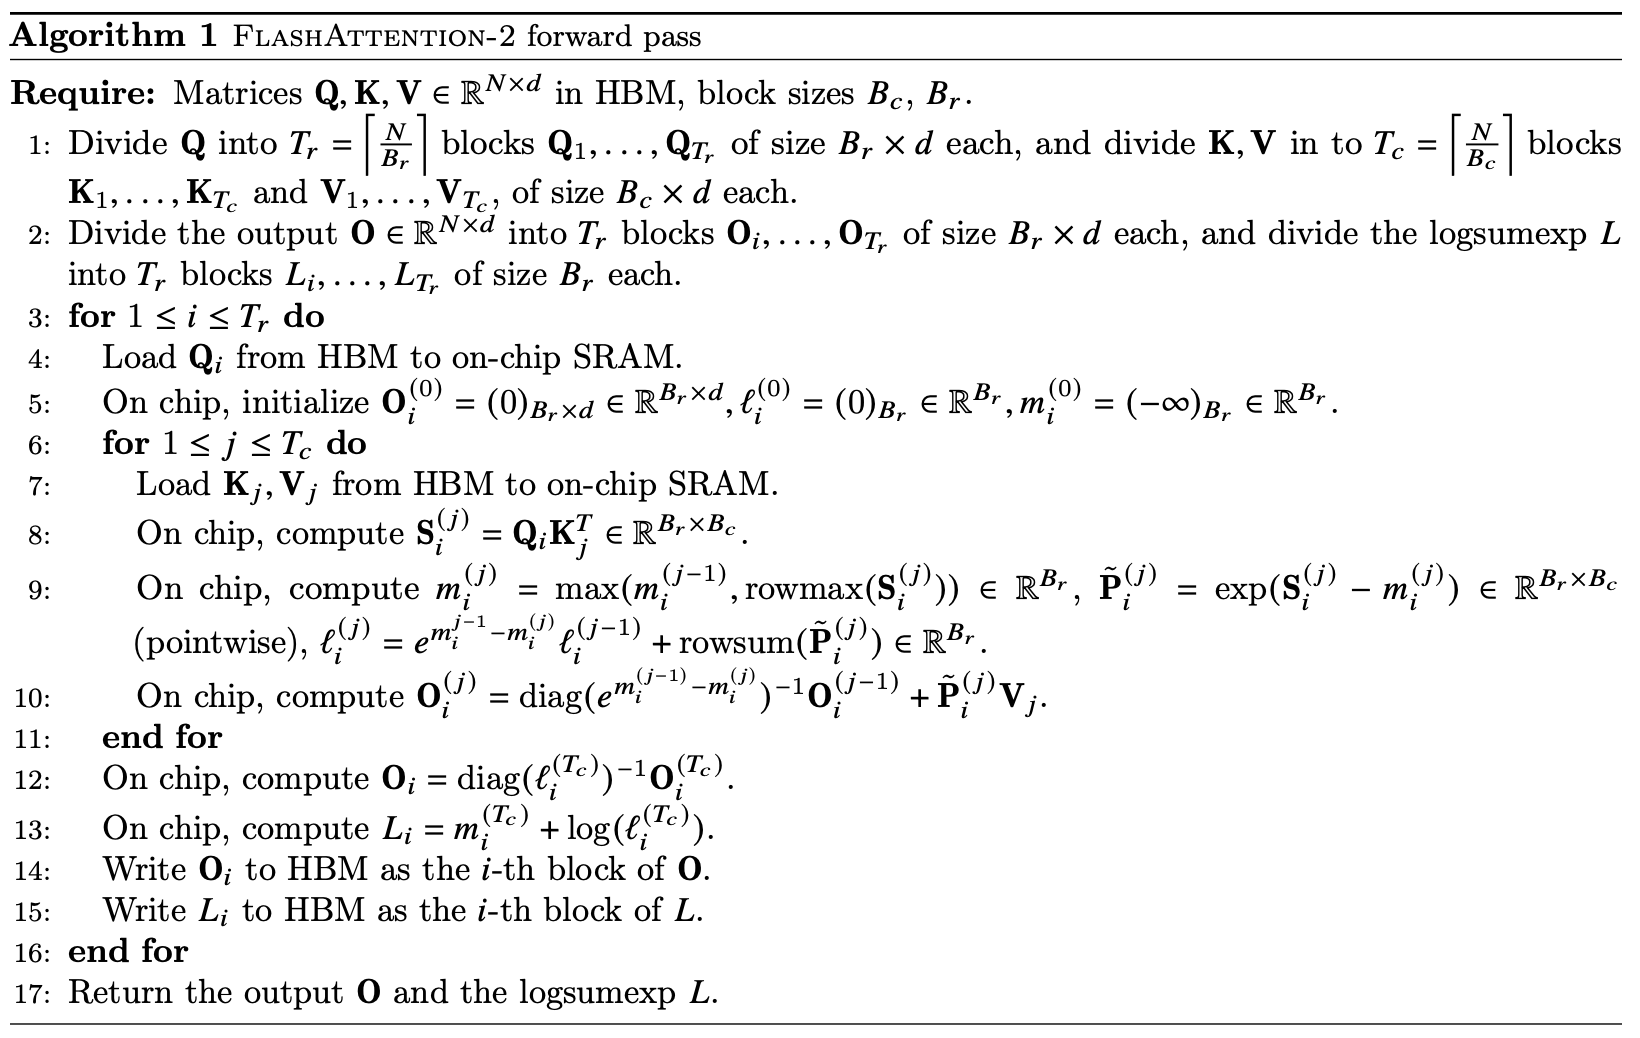

### Initialization

In [3]:

with np.printoptions(precision=2, suppress=True):
    print(f"Q \t\t K \t\t V")
    for q, k, v in zip(Q, K, V):
        print(f"{q} \t {k} \t {v}")


Q 		 K 		 V
[ 0.5  -0.14] 	 [ 0.24 -1.91] 	 [-0.54  0.11]
[0.65 1.52] 	 [-1.72 -0.56] 	 [-1.15  0.38]
[-0.23 -0.23] 	 [-1.01  0.31] 	 [-0.6  -0.29]
[1.58 0.77] 	 [-0.91 -1.41] 	 [-0.6   1.85]
[-0.47  0.54] 	 [ 1.47 -0.23] 	 [-0.01 -1.06]
[-0.46 -0.47] 	 [ 0.07 -1.42] 	 [ 0.82 -1.22]


In [4]:
# # Initialize output and intermediate arrays in HBM (using numpy arrays as example)
# O = np.zeros((N, d))
# l = np.zeros((N,1))
# m = -np.inf * np.ones((N,1))
# with np.printoptions(precision=2, suppress=True):
#     print(f"O \t\t l \t m")
#     for ro, rl, rm in zip(O, l, m):
#         print(f"{ro} \t {rl} \t {rm}")

In [5]:
# Divide Q into Tr blocks of size Br x d
Tr = math.ceil(N / Br)
print(f"Tr:{Tr} = ceil(N:{N} / Br:{Br})")
Q_blocks = [Q[i:i + Br] for i in range(0, len(Q), Br)]
with np.printoptions(precision=2, suppress=True):
    print("Q_blocks:")
    for i, block in enumerate(Q_blocks):
        print(f"{i+1}th")
        print(block)

Tr:3 = ceil(N:6 / Br:2)
Q_blocks:
1th
[[ 0.5  -0.14]
 [ 0.65  1.52]]
2th
[[-0.23 -0.23]
 [ 1.58  0.77]]
3th
[[-0.47  0.54]
 [-0.46 -0.47]]


In [6]:
# Divide K, V into Tc blocks of size Bc x d
Tc = math.ceil(N / Bc)
print(f"Tc:{Tc} = ceil(N:{N} / Bc:{Bc})")

K_blocks = [K[i:i + Bc] for i in range(0, len(K), Bc)]
V_blocks = [V[i:i + Bc] for i in range(0, len(V), Bc)]
with np.printoptions(precision=2, suppress=True):
    print(f"K_block \t\t V_block")
    for i, _ in enumerate(K_blocks):
        print(f"{i+1}th")
        print_matop(K_blocks[i], V_blocks[i])

hbm = {
    'K_blocks': K_blocks,
    'V_blocks': V_blocks,
    'Q_blocks': Q_blocks,
    'O':np.zeros((N, d))
}

Tc:2 = ceil(N:6 / Bc:3)
K_block 		 V_block
1th
[0.24 -1.91]		[-0.54 0.11]
[-1.72 -0.56]		[-1.15 0.38]
[-1.01 0.31]		[-0.60 -0.29]
2th
[-0.91 -1.41]		[-0.60 1.85]
[1.47 -0.23]		[-0.01 -1.06]
[0.07 -1.42]		[0.82 -1.22]


### Function

In [7]:
sram={}

def inner_iter(i, j, hbm=hbm, sram=sram):
    K_blocks = hbm['K_blocks']
    V_blocks = hbm['V_blocks']
    Q_blocks = hbm['Q_blocks']

    with np.printoptions(precision=2, suppress=True):
        # Load Q_i from HBM to on-chip SRAM
        Qi = Q_blocks[i-1]
        Kj = K_blocks[j-1]
        Vj = V_blocks[j-1]
        print('#' * 50)
        print(f"Processing blocks Q{i}, K{j}, V{j}")

        # Compute S_ij = Q_i * K_j^T
        Sij = Qi @ Kj.T
        print(f"S{i}{j}(Br, Bc) \t=\t Q{i}(Br, d) \t@\t K{j}^T (d, Bc):")
        print_matop(Sij, Qi, Kj.T, separator='\t')

        # Compute m_ij, exp(S_ij - m_ij), and l_ij
        mij = np.max(Sij, axis=1, keepdims=True)
        Sij_ = Sij - mij
        Pij = np.exp(Sij_)
        lij = np.sum(Pij, axis=1, keepdims=True)

        print(f"local row-wise max:")
        print(f"m{i}{j}(Br, 1) \t<=rowmax\t S{i}{j}(Br, Bc):")
        print_matop(mij, Sij, separator='\t\t\t\t')
        print(f"local softmax denominator:")
        print(f"l{i}{j}(Br, 1) \t<=rowsum\t P{i}{j}(Br, Bc) \t\t<=exp\t\t\t (S{i}{j} - m{i}{j}):")
        print_matop(lij, Pij, Sij_, separator='\t\t\t\t')

        # Retrieve previous values from SRAM
        Oi = sram['Oi']
        mi = sram['mi']
        li = sram['li']

        print(f'Continue from SRAM existing Output, Row_max and Softmax_denominator:')
        print(f'O{i} \t\t\t m{i} \t\t l{i}')
        print_matop(Oi, mi, li, separator='\t\t')

        # Update m_i
        mi_ = np.maximum(mi, mij)
        print(f"Updated cumulative max:")
        print(f"m{i}_(Br,1) \t=\t max(m{i} \t,\t m{i}{j})")
        print_matop(mi_, mi, mij, separator='\t\t\t')

        # Calculate li_ (new l_i)
        past_scaled_l = np.exp(mi - mi_) * li
        local_l = np.exp(mij - mi_) * lij
        li_ = past_scaled_l + local_l
        print(f"updated cumulative softmax denominator:")
        print(f"l{i}_(Br,1) \t=\t exp(m{i}-m{i}_) \t*\t l{i} \t\t+\t exp(m{i}{j}-m{i}_) \t*\t l{i}{j}")
        print_matop(li_, np.exp(mi - mi_), li, np.exp(mij-mi_), lij, separator='\t\t\t')

        # Update O_i
        inv_li_ = np.diag(1.0 / li_.flatten())
        scaled_Oi = np.diag(li.flatten()) @ (np.exp(mi-mi_) * Oi)
        print(f"scaled cumulative Output of previous blocks, i.e. [from Q0 to Q{i-1}] @ K{j}.T @ V{j}")
        print(f"scaled_O{i} \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_) \t*\t O{i}] \t=\t diag(l{i}) \t@\t [exp(m{i}-m{i}_)*O{i}]")
        print_matop(scaled_Oi, np.diag(li.flatten()), np.exp(mi-mi_), Oi, np.diag(li.flatten()), np.exp(mi-mi_)*Oi)

        scaled_PV = np.exp(mij - mi_) * Pij @ Vj
        print(f"scaled local P@V of current block")
        print(f"scaled_PV \t=\t exp(m{i}{j}-m{i}_) \t*\t [P{i}{j} \t\t@\t V{j}] \t=\t exp(m{i}{j}-m{i}_) \t*\t PV")
        print_matop(scaled_PV, np.exp(mij - mi_), Pij, Vj, np.exp(mij - mi_), Pij@Vj, separator='\t\t')

        Oi_ = inv_li_ @ (scaled_Oi + scaled_PV)
        print(f"updated cumulative Output of all blocks, i.e. [from Q0 to Q{i}] @ K{j}.T @ V{j}")
        print(f"O{i}_ (Br,d) \t=\t inv_l{i}_\t@\t (scaled_O{i}\t+\t scaled_PV)")
        print_matop(Oi_, inv_li_, scaled_Oi, scaled_PV, separator='\t\t')

        # Retain the intermediate Oi, li, mi in SRAM
        sram['Oi'] = Oi_
        sram['li'] = li_
        sram['mi'] = mi_

    return hbm, sram

### Iteration

In [8]:
for i in range(1, len(Q_blocks) + 1):
    # reinitialize Oi, li, mi for each row i
    Oi = np.zeros((Br, d))
    li = np.zeros((Br,1))
    mi = -np.inf * np.ones((Br,1))
    sram = {
        'Oi': Oi,
        'li': li,
        'mi': mi}
    for j in range(1, len(K_blocks) + 1):
        hbm, sram = inner_iter(i, j, hbm=hbm, sram=sram)
    print(f"After processing row {i}")
    print(f"Save O{i} to HBM")
    hbm['O'][(i-1)*Br:i*Br] = sram['Oi']
    print_matop(hbm['O'])


##################################################
Processing blocks Q1, K1, V1
S11(Br, Bc) 	=	 Q1(Br, d) 	@	 K1^T (d, Bc):
[0.38 -0.78 -0.55]	[0.50 -0.14]	[0.24 -1.72 -1.01]
[-2.76 -1.97 -0.18]	[0.65 1.52]	[-1.91 -0.56 0.31]
local row-wise max:
m11(Br, 1) 	<=rowmax	 S11(Br, Bc):
[0.38]				[0.38 -0.78 -0.55]
[-0.18]				[-2.76 -1.97 -0.18]
local softmax denominator:
l11(Br, 1) 	<=rowsum	 P11(Br, Bc) 		<=exp			 (S11 - m11):
[1.71]				[1.00 0.31 0.39]				[0.00 -1.16 -0.93]
[1.24]				[0.08 0.17 1.00]				[-2.58 -1.80 0.00]
Continue from SRAM existing Output, Row_max and Softmax_denominator:
O1 			 m1 		 l1
[0.00 0.00]		[-inf]		[0.00]
[0.00 0.00]		[-inf]		[0.00]
Updated cumulative max:
m1_(Br,1) 	=	 max(m1 	,	 m11)
[0.38]			[-inf]			[0.38]
[-0.18]			[-inf]			[-0.18]
updated cumulative softmax denominator:
l1_(Br,1) 	=	 exp(m1-m1_) 	*	 l1 		+	 exp(m11-m1_) 	*	 l11
[1.71]			[0.00]			[0.00]			[1.00]			[1.71]
[1.24]			[0.00]			[0.00]			[1.00]			[1.24]
scaled cumulative Output of previous blocks,